In [2]:
import os
import sys
from facet.facet import facet
from loguru import logger
from mne.annotations import Annotations
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("../../src")
from facet.Epilepsy.template_utils import annotate_spike, extract_template, find_spike_template
from facet.Epilepsy.template_utils import detect_spike_matches, plot_match_with_template, basic_clean, flag_muscle_ics
import scipy.stats as st
from scipy.signal import find_peaks

os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))

logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("facet.log", level="DEBUG")

eegDataSet = "../datasets/test_epilepsy_eeg.edf"


f = facet()

2025-05-25 05:21:19.387 | ERROR    | facet.helpers.fastranc:<module>:23 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll does not exist. Run the build.py script to create the file.
2025-05-25 05:21:19.388 | ERROR    | facet.helpers.fastranc:<module>:40 - File c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers/fastranc.dll could not be opened! Check your Project Files Message: Could not find module 'c:\Users\E\AppData\Local\Programs\Python\Python312\Lib\site-packages\facet\helpers\fastranc.dll' (or one of its dependencies). Try using the full path with constructor syntax.
2025-05-25 05:21:19.388 | INFO     | facet.helpers.fastranc:<module>:41 - Current working directory: g:\Medical Engineering and Analytics\Facetpy\FACETpy-main\FACETpy-main\examples\epilepsynotebooks


### Import

2025-05-25 05:21:23.089 | INFO     | facet.facet:import_eeg:33 - Importing EEG from ../datasets/test_epilepsy_eeg.edf


Max amplitude after scaling: 296.52834784033575


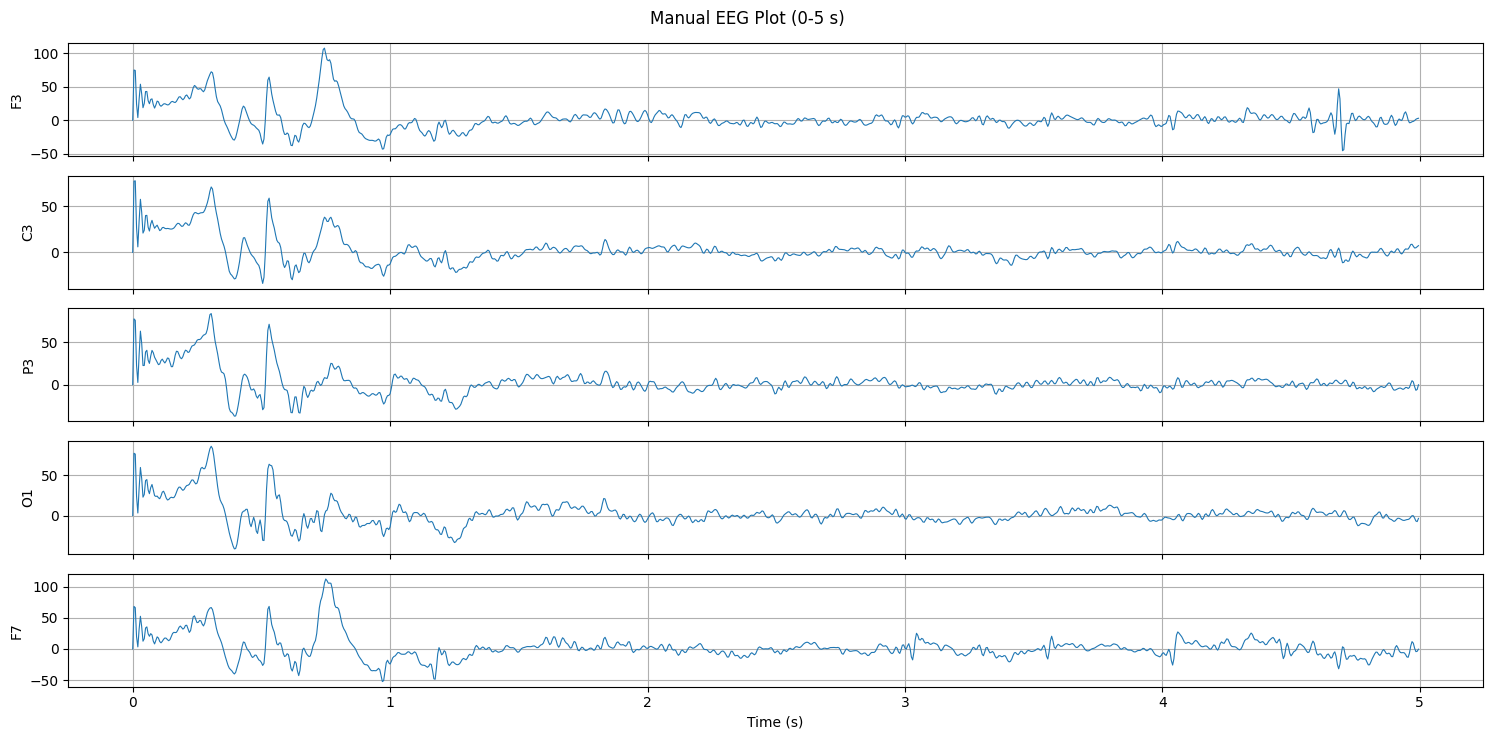

In [3]:
#Import EEG using FACET
f.import_eeg(eegDataSet, artifact_to_trigger_offset=-0.005, bads=["EMG", "ECG"])

raw = f.get_eeg().mne_raw

raw.set_montage('standard_1020', on_missing='warn')
#Step 2 — Force scaling to µV range

raw.set_channel_types({ch: 'eeg' for ch in raw.ch_names})
raw.set_montage('standard_1020')

# Step 3 — Filter cleanly
raw.filter(l_freq=1.0, h_freq=40.0, fir_design='firwin')


# Step 4 — Re-check amplitude
print("Max amplitude after scaling:", raw.get_data().max())


def plot_clean_eeg(raw, picks=None, start_time=0, duration=5, scale=1.0):
    """
    Plot EEG channels manually (clean scaling, no autoscaling errors).
    - scale: multiply data by this to convert to µV if needed
    """
    sfreq = raw.info['sfreq']
    start_sample = int(start_time * sfreq)
    end_sample = int((start_time + duration) * sfreq)

    if picks is None:
        picks = raw.ch_names[:5]  # first 5 channels by default

    fig, axs = plt.subplots(len(picks), 1, figsize=(15, 1.5 * len(picks)), sharex=True)

    for i, ch in enumerate(picks):
        ch_idx = raw.ch_names.index(ch)
        data, times = raw.get_data(picks=[ch_idx], start=start_sample, stop=end_sample, return_times=True)
        axs[i].plot(times, data[0] * scale, linewidth=0.8)
        axs[i].set_ylabel(f"{ch}")
        axs[i].grid(True)

    axs[-1].set_xlabel("Time (s)")
    plt.suptitle(f"Manual EEG Plot ({start_time}-{start_time + duration} s)")
    plt.tight_layout()
    plt.show()

# Try zoomed-in plots
plot_clean_eeg(raw, picks=["F3", "C3", "P3", "O1", "F7"], start_time=0, duration=5, scale=1.0)

### manual spike detection

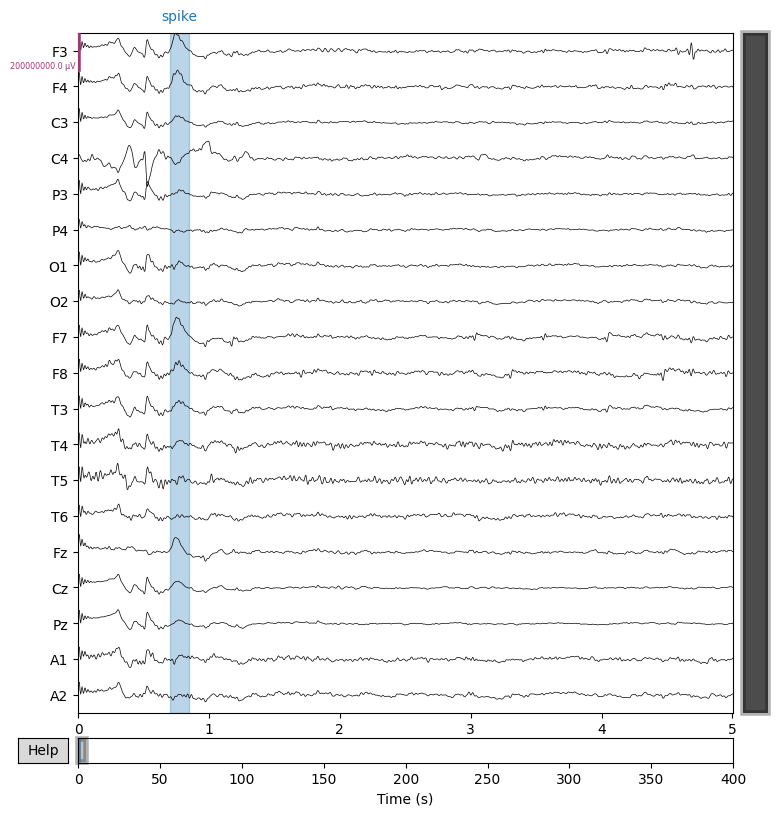

In [4]:

raw = annotate_spike(raw, onset=0.70, duration=0.15)

### Extract template manually

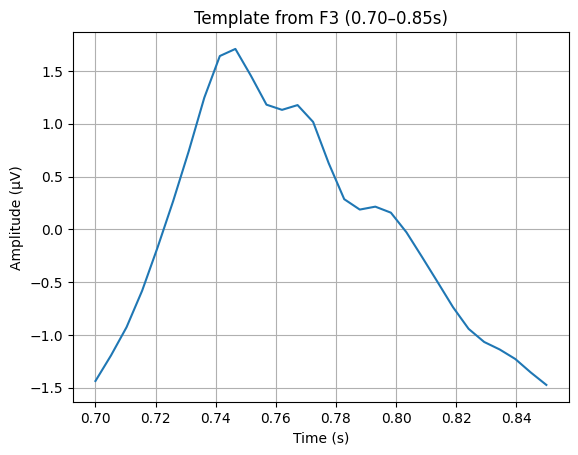

In [15]:
raw_for_templates = raw
template = extract_template(
        raw_for_templates, channel="F3",
        start_time=0.70, end_time=0.85)

### Auto extract template

Max F3: 192.5905127663752
Indices above 12: [    1     2     3 ... 79996 79997 79998]
Result type: <class 'numpy.ndarray'>
Length: 16
Contents: [-1.69977477  2.02378954  1.99185892 -0.50371772 -1.50565231 -0.13386396
  0.96990319  0.24546193 -0.77285277 -0.46087365  0.42574014  0.42867143
 -0.25226565 -0.48000021 -0.16026687 -0.11615725]


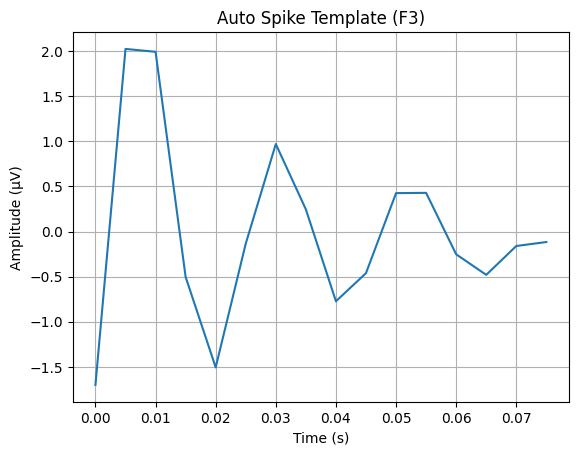

In [18]:
channel = "F3"

data = raw.copy().get_data(picks="F3").flatten()
print("Max F3:", data.max())
print("Indices above 12:", np.where(np.abs(data) > 12)[0])

template, spike_times, center_time = find_spike_template(
        raw_for_templates, channel=channel, threshold=100)
print("Result type:", type(template))
print("Length:", len(template))
print("Contents:", template)



plt.plot(spike_times, template)
plt.title("Auto Spike Template (F3)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.grid(True)
plt.show()


#save template
np.save("spike_template_F3.npy", template)

### Cross correlation

In [12]:
#  
template_values, _, _ = find_spike_template(raw, channel="F3", threshold=100)

#detect matches using the template
match_times, match_scores = detect_spike_matches(raw, "F3", template, threshold_ratio=0.6)

#visualize matches
plot_match_with_template(raw, "F3", match_times, template, raw.info["sfreq"])

In [14]:
channel_scores = {}
top_score = -np.inf
top_channel = None
top_time = None
raw_for_templates = raw

for ch in raw.info['ch_names']:
    match_times, match_scores = detect_spike_matches(raw_for_templates, ch, template, threshold_ratio=0.8)
    channel_scores[ch] = len(match_times)

    # Check if this channel has a new highest score
    if match_scores:  # Make sure it's not empty
        max_idx = np.argmax(match_scores)
        if match_scores[max_idx] > top_score:
            top_score = match_scores[max_idx]
            top_channel = ch
            top_time = match_times[max_idx]

# Print sorted channels by match count
sorted_channels = sorted(channel_scores.items(), key=lambda x: x[1], reverse=True)
for ch, count in sorted_channels:
    print(f"{ch}: {count} matches")

# Print the best individual match overall
if top_time is not None:
    print(f"\nBest single match: {top_channel} at {top_time:.2f}s (score = {top_score:.2f})")
    plot_match_with_template(raw, top_channel, [top_time], template, raw.info["sfreq"])
else:
    print("\nNo spike match passed the threshold on any channel.")


match_times, match_scores = detect_spike_matches(raw, "F3", template, threshold_ratio=0.8)

# Sort scores to find best ones
top_matches = sorted(zip(match_times, match_scores), key=lambda x: x[1], reverse=True)

# Plot top 3 matches for visual inspection
for t, score in top_matches[:3]:
    plot_match_with_template(raw, "F3", [t], template, raw.info['sfreq'])

F3: 0 matches
F4: 0 matches
C3: 0 matches
C4: 0 matches
P3: 0 matches
P4: 0 matches
O1: 0 matches
O2: 0 matches
F7: 0 matches
F8: 0 matches
T3: 0 matches
T4: 0 matches
T5: 0 matches
T6: 0 matches
Fz: 0 matches
Cz: 0 matches
Pz: 0 matches
A1: 0 matches
A2: 0 matches

No spike match passed the threshold on any channel.
